<a href="https://colab.research.google.com/github/elain-b/forest-area-database-LSTM/blob/main/watch_forest_cover_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv

with open('../content/forest-area-as-share-of-land-area.csv', 'r') as f:
  reader = csv.reader(f)
  for line in reader :
    print(line)

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
import math
df = pd.read_csv('../content/forest-area-as-share-of-land-area.csv')
df.head()
# df.plot.bar(figsize=(9, 6))
# df.plot(figsize=(9, 6))

,Entity,Code,Year,Forest cover
0,Afghanistan,AFG,1990,1.850994
1,Afghanistan,AFG,1991,1.850994
2,Afghanistan,AFG,1992,1.850994
3,Afghanistan,AFG,1993,1.850994
4,Afghanistan,AFG,1994,1.850994


In [2]:
look_back = 1
epochs = 30
batch_size = 1

In [3]:
dataset = df['Forest cover']
ds = dataset.values
ds = ds.astype('float32')
ds = ds.reshape((-1,1))

scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)
print(ds)

[[0.00762533]
 [0.00762533]
 [0.00762533]
 ...
 [0.18674944]
 [0.18625884]
 [0.18576825]]


In [4]:
train_size = int(len(ds) * 0.67)
test_size = len(ds) - train_size
train, test = ds[:train_size,:], ds[train_size:len(ds),:]
print(len(train), len(test))

5342 2632


In [5]:
def createdataset(dataset, lookback):
  dataX, dataY = [], []
  for i in range(len(dataset)-lookback-1):
    a = dataset[i:(i+lookback), ]
    dataX.append(a)
    dataY.append(dataset[i + look_back, ])
  return np.array(dataX), np.array(dataY)

trainX, trainY = createdataset(train, look_back)
testX, testY = createdataset(test, look_back)
(trainX.shape, trainY.shape, testX.shape, testY.shape)

((5340, 1, 1), (5340, 1), (2630, 1, 1), (2630, 1))

In [6]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
(trainX.shape, testX.shape)

((5340, 1, 1), (2630, 1, 1))

In [7]:
# LSTMネットワークを作成し、適合させる
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,verbose=2)

Epoch 1/30
5340/5340 - 6s - loss: 0.0027
Epoch 2/30
5340/5340 - 5s - loss: 8.6199e-04
Epoch 3/30
5340/5340 - 5s - loss: 8.4039e-04
Epoch 4/30
5340/5340 - 5s - loss: 8.3323e-04
Epoch 5/30
5340/5340 - 5s - loss: 8.2114e-04
Epoch 6/30
5340/5340 - 5s - loss: 8.1833e-04
Epoch 7/30
5340/5340 - 5s - loss: 8.0995e-04
Epoch 8/30
5340/5340 - 5s - loss: 8.0794e-04
Epoch 9/30
5340/5340 - 5s - loss: 7.9975e-04
Epoch 10/30
5340/5340 - 5s - loss: 8.0148e-04
Epoch 11/30
5340/5340 - 5s - loss: 8.0241e-04
Epoch 12/30
5340/5340 - 5s - loss: 7.9534e-04
Epoch 13/30
5340/5340 - 5s - loss: 7.9909e-04
Epoch 14/30
5340/5340 - 5s - loss: 7.8961e-04
Epoch 15/30
5340/5340 - 5s - loss: 7.8981e-04
Epoch 16/30
5340/5340 - 5s - loss: 7.8720e-04
Epoch 17/30
5340/5340 - 5s - loss: 7.9482e-04
Epoch 18/30
5340/5340 - 5s - loss: 7.8751e-04
Epoch 19/30
5340/5340 - 5s - loss: 7.8737e-04
Epoch 20/30
5340/5340 - 5s - loss: 7.9166e-04
Epoch 21/30
5340/5340 - 5s - loss: 7.8568e-04
Epoch 22/30
5340/5340 - 5s - loss: 7.8833e-04
E

In [8]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [21]:
trainY = trainY.reshape(trainY.shape[0], -1)

# 予測値と目標を非スケールに反転させる
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [33]:
# 根底平均二乗誤差を求める
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

Train Score: inf RMSE
Test Score: 2335895.61980 RMSE


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


In [35]:
# プロット用学習データのシフト予測
trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# プロット用テストデータのシフト予測
testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict

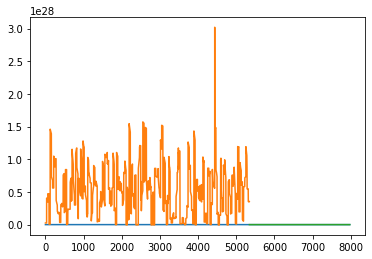

In [43]:
# ベースラインと予測値をプロットする
plt.plot(scaler.inverse_transform(ds))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(figsize=(16))
plt.show()